# Use Essentia Library

### Load Audio

In [ ]:
!pip3 install essentia

In [ ]:
SR=44100

In [ ]:
!pip3 install --upgrade soundfile

In [120]:
DELAY=7854

In [121]:
root_path = f"../data/test/midi_{DELAY}.m4a"

In [61]:
BPM=100

In [122]:
from essentia.standard import *
from tempfile import TemporaryDirectory
import librosa


# Load audio file.
data, sr = librosa.load(root_path, sr=SR)
audio = MonoLoader(filename=root_path)()

# # librosa.effects.trim은 Librosa 라이브러리의 함수로, 오디오 신호에서 시작과 끝의 정적인 소음을 자르거나 제거하는 데 사용됩니다.
# audio = librosa.effects.trim(audio, top_db=5000, frame_length=1024, hop_length=512)[0]

/tmp/ipykernel_48505/2770850161.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(root_path, sr=SR)
/home/sua/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [67]:
audio, sr

(array([ 9.0405229e-06,  1.5872647e-06,  2.4934416e-06, ...,
        -2.1628239e-07,  2.8815779e-05,  8.2720886e-05], dtype=float32),
 44100)

### Onset Detection

In [123]:
# 1. Compute the onset detection function (ODF).

# The OnsetDetection algorithm provides various ODFs.
od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(audio, frameSize=2048, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
    pool.add('odf.complex', od_complex(magnitude, phase))

# 2. Detect onset locations.
onsets = Onsets()

onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                    essentia.array([pool['odf.hfc']]),
                    # You need to specify weights, but if we use only one ODF
                    # it doesn't actually matter which weight to give it
                    [1])

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])


# Add onset markers to the audio and save it to a file.
# We use beeps instead of white noise and stereo signal as it's more distinctive.

# We want to keep beeps in a separate audio channel.
# Add them to a silent audio and use the original audio as another channel. Mux both into a stereo signal.
# silence = [0.] * len(audio)

# beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
# beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)

# audio_hfc = StereoMuxer()(audio, beeps_hfc)
# audio_complex = StereoMuxer()(audio, beeps_complex)

# # Write audio to files in a temporary directory.
# temp_dir = TemporaryDirectory()
# AudioWriter(filename=temp_dir.name + '/hiphop_onsets_hfc_stereo.mp3', format='mp3')(audio_hfc)
# AudioWriter(filename=temp_dir.name + '/hiphop_onsets_complex_stereo.mp3', format='mp3')(audio_complex)

In [124]:
onsets_hfc

array([ 1.021678 ,  2.4729252,  3.065034 ,  3.668753 ,  4.2724714,
        4.8645806,  5.4682994,  6.072018 ,  6.664127 ,  7.2678456,
        7.8715644,  8.463674 ,  9.067392 ,  9.671111 , 10.26322  ,
       10.866939 , 11.470657 , 12.062766 , 12.666485 , 13.270205 ,
       13.862313 , 14.466032 , 15.069751 , 15.67347  , 16.265577 ,
       16.869297 , 17.171156 , 17.473017 , 17.763266 , 18.065125 ,
       18.366983 , 18.668844 , 18.970703 , 19.272562 , 19.56281  ,
       19.864672 , 20.16653  , 20.46839  , 20.77025  , 21.07211  ,
       21.373968 , 21.664217 , 21.838367 , 21.989298 , 22.140226 ,
       22.279547 , 22.430477 , 22.581406 , 22.732336 , 22.883265 ,
       23.034195 , 23.185125 , 23.336054 , 23.486984 , 23.637915 ,
       23.788843 , 23.939774 , 25.61161  ], dtype=float32)

### Show Graph

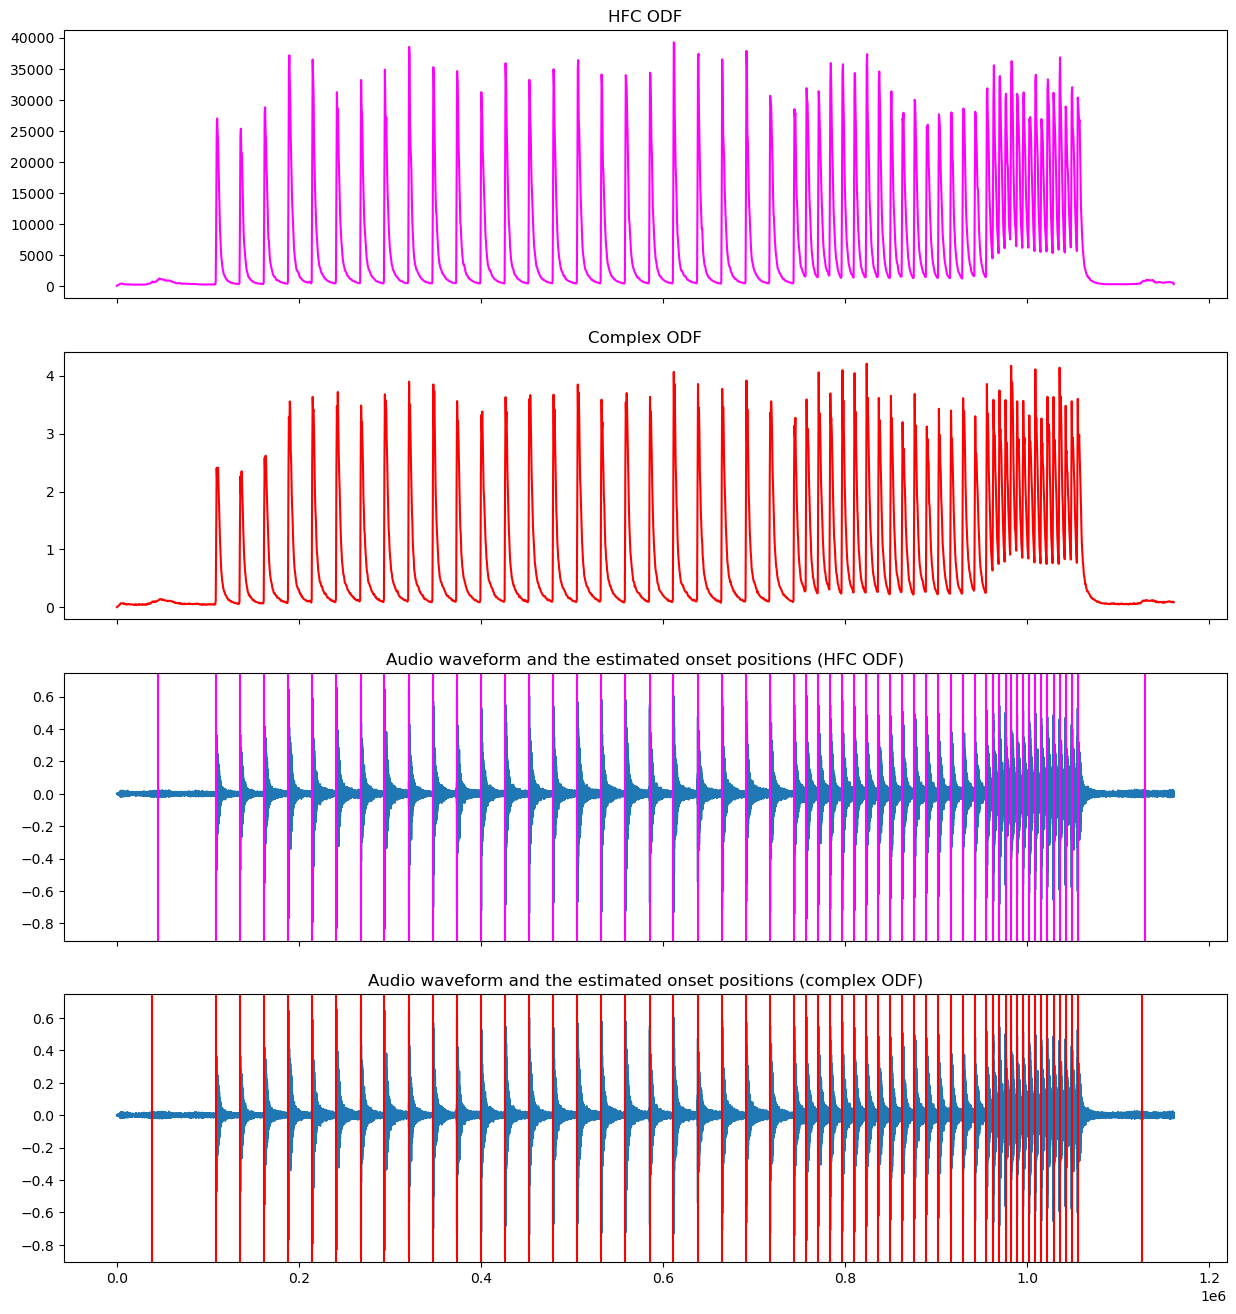

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy
n_frames = len(pool['odf.hfc'])
frames_position_samples = numpy.array(range(n_frames)) * 512

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15, 16))

ax1.set_title('HFC ODF')
ax1.plot(frames_position_samples, pool['odf.hfc'], color='magenta')

ax2.set_title('Complex ODF')
ax2.plot(frames_position_samples, pool['odf.complex'], color='red')

ax3.set_title('Audio waveform and the estimated onset positions (HFC ODF)')
ax3.plot(audio)
for onset in onsets_hfc:
    ax3.axvline(x=onset*44100, color='magenta')

ax4.set_title('Audio waveform and the estimated onset positions (complex ODF)')
ax4.plot(audio)
for onset in onsets_complex:
    ax4.axvline(x=onset*44100, color='red')

### Separate Audio

In [ ]:
# data separate
onsets_hfc[0]

In [ ]:
!pip3 install sox

In [ ]:
ln = len(data)//2

In [ ]:
import librosa

start = (int)((onsets_hfc[0]-0.1) * sr)
end = (int)((onsets_hfc[0]+0.1) * sr)

print(end)

duration = 0.1
new_end = (int)((onsets_hfc[0] + duration) * sr)
print(new_end)
end = min(end, new_end)

print(start)
print(end)

trimmed = data[start:end]

trimmed

# librosa.output.write_wav("/content/drive/MyDrive/Colab Notebooks/data/trimmed_data/examples.wav", trimmed, sr)

In [ ]:
import scipy.io.wavfile
scipy.io.wavfile.write("../data/test/examples.wav", sr, trimmed)

In [ ]:
from IPython.display import Audio, display

display(Audio("../data/test/examples.wav"))

# Use Librosa Library

In [ ]:
!pip3 install librosa

In [ ]:
!pip3 install numpy

In [ ]:
import librosa
import numpy as np

y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/data/per_drum/1_HH/16/HH_16_0001.m4a')
onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         aggregate=np.median,
                                         fmax=8000, n_mels=256)
peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=10)
peaks

In [ ]:
import matplotlib.pyplot as plt
times = librosa.times_like(onset_env, sr=sr, hop_length=512)
fig, ax = plt.subplots(nrows=2, sharex=True)
D = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[0].plot(times, onset_env, alpha=0.8, label='Onset strength')
ax[0].vlines(times[peaks], 0,
             onset_env.max(), color='r', alpha=0.8,
             label='Selected peaks')
ax[0].legend(frameon=True, framealpha=0.8)
ax[0].label_outer()

# Acustic Drum Data Load & Separate


In [ ]:
!pip3 install glob2

In [ ]:
SR = 44100

In [ ]:
ONSET_DURATION = 0.1

In [ ]:
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  return onsets_hfc

In [11]:
import essentia
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# onset detection function
def onset_detection(audio):
  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  return onsets_hfc

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [ ]:
# trimmed audio
def audio_trim_per_onset(audio, onsets, sr=SR, duration=ONSET_DURATION):
  trimmed_audios = []
  for i in range(0, len(onsets)):
    start = (int)((onsets[i]) * sr)
    if i + 1 < len(onsets):
      end_by_onset = (int)(onsets[i + 1] * sr)
    end_by_duration = (int)((onsets[i] + duration) * sr)

    if i + 1 < len(onsets):
      end = min(end_by_onset, end_by_duration)
    else:
      end = end_by_duration

    trimmed = audio[start:end]
    trimmed_audios.append(trimmed)

  return trimmed_audios


In [ ]:
import scipy.io.wavfile

# trimmed audio -> wav file write
def write_trimmed_audio(root_path, name, trimmed_audios):
  start = 1
  for audio in trimmed_audios:
    # exist or not
    if not os.path.exists(root_path):
      # if the demo_folder directory is not present
      # then create it.
      os.makedirs(root_path)
    scipy.io.wavfile.write(f'{root_path}/{name}_{start:04}.wav', sr, audio)
    start += 1

### for test

In [ ]:
import os

# trimming audio
trimmed_audios = audio_trim_per_onset(data, onsets_hfc, sr)
# print(trimmed_audios)

# new_file write
trim_root_path = '../data/trim_data/'
name = 'example'
write_trimmed_audio(trim_root_path, name, trimmed_audios)

In [ ]:
from IPython.display import Audio, display

wavs = os.listdir(trim_root_path)
for w in wavs:
  display(Audio(f'{trim_root_path}/{w}'))

### real

In [ ]:
import os
import librosa

# load audio & trimmed per onset
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def main(root_path, trim_path):
  datas = os.listdir(root_path)

  check = False
  for d in datas:
    if d.endswith('.m4a'):
      check = True
      wav = os.path.join(root_path, d)
      print(wav)

      # detect onsets
      onsets = onset_detect(wav)
      # print(onsets)

      # trimming audio
      audio, sr = librosa.load(wav, sr=SR)
      trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
      # print(trimmed_audios)

      # new_file write
      name = d[:-4]
      write_trimmed_audio(trim_path, name, trimmed_audios)
    elif d.endswith('.txt') == False:
      new_root_path = os.path.join(root_path, d)
      new_trim_path = os.path.join(trim_path, d)
      main(new_root_path, new_trim_path)

In [ ]:
# 드럼 녹음 data path
input_file_path = "/pattern/P2/16"
root_path = "../data/raw_data" + input_file_path
trim_path = "../data/trim_data" + input_file_path
main(root_path, trim_path)

### Trash

In [ ]:
import os
import librosa

# load audio & trimmed per onset
def main_backup(root_path, trim_path):
  drum_folders = os.listdir(root_path)
  # [pattern, per_drum]
  for drum_folder in drum_folders:
    drum_folder_path = os.path.join(root_path, drum_folder)
    try:
      element_folder = os.listdir(drum_folder_path)
      # per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
      for element in element_folder:
        element_folder_path = os.path.join(drum_folder_path, element)
        rhythm_folder = os.listdir(element_folder_path)
        # 04, 08, 16
        for rhythm in rhythm_folder:
          rhythm_folder_path = os.path.join(element_folder_path, rhythm)
          files = os.listdir(rhythm_folder_path)
          wav_files = [os.path.join(rhythm_folder_path, file) for file in files if file.endswith('.m4a')]
          for wav in wav_files:
            # print(wav)
            # detect onsets
            onsets = onset_detect(wav)
            # print(onsets)

            # trimming audio
            audio, sr = librosa.load(wav, sr=SR)
            trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
            # print(trimmed_audios)

            # new_file write
            trim_root_path = os.path.join(trim_path, drum_folder, element, rhythm)
            name = os.path.basename(wav).split('/')[-1][:-4]
            write_trimmed_audio(trim_root_path, name, trimmed_audios)

    except Exception as e:
      print(e)

# Rhythm Detection

In [5]:
SR = 44100

In [10]:
import math

"""
마디 단위별로 온셋 포인트 구하는 함수
@param onset_full_audio: 전체 wav에 대한 onset time
@param sec_of_bar: 한 마디가 몇 초인지
@param bar_num: 마디 총 개수

return 마디 단위별로의 온셋 time (마디의 처음 시작을 0, 끝을 1로 했을 때 기준으로)
"""
def calculate_onset_per_bar(onset_full_audio, sec_of_bar, bar_num):
    onset_per_bar = [[] for i in range(bar_num)] # 마디 개수만큼 row 초기화

    # 전체 wav에 대한 onset 
    for onset in onset_full_audio:
        idx = math.floor(onset / sec_of_bar) # 몇 번째 마디인지
        onset_point_in_bar = (onset - sec_of_bar * idx) / sec_of_bar # idx 마디에서 몇 박자 뒤에 등장하는지 (0 ~ 1)
        onset_per_bar[idx].append(onset_point_in_bar)
   
    return onset_per_bar

In [9]:
import math

""" 
전체 wav와 bpm이 주어졌을 때, rhythm을 계산하는 함수
@param audio_wav: wav array
@param bpm: 분당 음표 개수 (4/4박자 기준)
"""
def rhythm_detection(audio_wav, bpm):
    rhythm_per_bar = 4.0 # 한 마디에 4분음표가 몇 개 들어가는지
    rhythm_per_sec = bpm / 60.0 # 한 초당 몇 박 나오는지
    sec_of_bar = (1.0 / rhythm_per_sec) * rhythm_per_bar # 한 마디가 몇 초인지
    bar_num = math.ceil((len(audio_wav) / SR) / sec_of_bar) # 총 마디 개수
    print(sec_of_bar, bar_num)

    bars = [] # 한 마디당 wav 정보
    step = (int)(sec_of_bar * SR) # 한 마디에 들어가는 정보량
    for i in range(0, len(audio_wav), step):
        bars.append(audio_wav[i:i+step])

    onset_full_audio = onset_detection(audio_wav) # 전체 wav에 대한 onset time
    onset_per_bar = calculate_onset_per_bar(onset_full_audio, sec_of_bar, bar_num) # 한 마디당 rhythm 정보
    
    return onset_per_bar

In [8]:
def get_rhythm(audio_wav, bpm, is_our_train_data=False):
    if is_our_train_data:
        onset_full_audio = onset_detection(audio_wav)
        audio_wav = audio_wav[(int)(onset_full_audio[0] * SR):]
    
    return rhythm_detection(audio_wav, bpm)

In [3]:
import os

# load audio path
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def get_audio_paths(root_path):
  if os.path.isfile(root_path):
    if root_path.endswith('m4a'):
      return [root_path]
    else:
      return []  

  folders = os.listdir(root_path)
  audio_paths = []

  for d in folders:
    new_root_path = os.path.join(root_path, d)
    audio_paths += get_audio_paths(new_root_path)
      
  return audio_paths

### 현재 train data로 rhythm detection 잘 되는지 확인

In [ ]:
import librosa
import itertools

root_path="../data/raw_data/pattern/P1/08/"

inputs = get_audio_paths(root_path)

for i in inputs:
    data, sr = librosa.load(i, sr=SR)
    bars = get_rhythm(data, 100, True)
    print(bars)

# audio delay만큼 자르기

In [19]:
import numpy as np

def manage_delay_time(audio, delay_micro_sec):
    start_point = delay_micro_sec * (SR / 1000000) 
    if delay_micro_sec < 0:
        start_point = start_point * (-1)
        start_empty_list = np.array([0.0] * (int)(start_point), dtype=np.float32)
        result = np.concatenate((start_empty_list, audio), axis=0)
    else:
        result = audio[(int)(start_point):]
    return result
    

In [126]:
import librosa
import itertools

inputs = get_audio_paths(root_path)

data, sr = librosa.load(inputs[0], sr=SR)

new_data = manage_delay_time(data, DELAY - 30000)

bars = get_rhythm(new_data, BPM)
for b in bars:
    print(b)

/tmp/ipykernel_48505/1546442645.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(inputs[0], sr=SR)
/home/sua/anaconda3/envs/drum/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


2.4 11
[0.4402116437753042]
[0.04006042083104455, 0.28677248954772955, 0.5383219718933107, 0.7898714542388917]
[0.03658342361450203, 0.28813310464223235, 0.5396825869878135, 0.7863945563634238]
[0.03794403870900502, 0.2894935210545861, 0.5362056891123457, 0.7877551714579267]
[0.03930465380350764, 0.286016623179118, 0.5375661055246991, 0.7891155878702801]
[0.035827557245890304, 0.2873770395914714, 0.5389265219370525, 0.7856388886769613]
[0.03718837102254291, 0.28873785336812396, 0.540287335713705, 0.7869989077250169]
[0.03854878743489554, 0.16432332992553683, 0.2900978724161781, 0.4110356966654457, 0.5368102391560869, 0.6625847816467283, 0.7883601188659666, 0.9141346613566078]
[0.03990920384724965, 0.16084623336792023, 0.28662157058715854, 0.4123961130777998, 0.5381706555684411, 0.6639451980590824, 0.7897205352783206, 0.9154950777689619]
[0.03643210728963305, 0.1089948018391936, 0.17188247044881275, 0.23476934432983487, 0.2928194999694833, 0.35570637385050546, 0.4185940424601246, 0.4814